In [9]:
import numpy as np
import yfinance as yf
import requests
import pickle

import matplotlib.pyplot as plt

In [114]:
def get_historical_data(symbol, period="5min"):
    
    if period == "5min":
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={period}&outputsize=full&apikey=demo"
    elif period == "Daily":
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey=demo"
    
    r = requests.get(url)
    data = r.json()
    
    return data

In [101]:
def remove_after_hour_data(data, period="5min"):
    
    key_string = "Time Series (" + period + ")"
    
    if period != "Daily":
        
        dates_list = list(data[key_string].keys())
        bool_list = [(int(d.split(" ")[-1].split(":")[0]) < 16) and (int(d.split(" ")[-1].split(":")[0]) > 8) for d in dates_list]
        
        data_array = np.array(list(data[key_string].values()))[bool_list]
        date_array = np.array(list(data[key_string].keys()))[bool_list]
    
    else:
        
        data_array = np.array(list(data[key_string].values()))
        date_array = np.array(list(data[key_string].keys()))
    
    return date_array, data_array

In [109]:
def split_data_by_day(date_array, data_array):
    
    days = np.array([d.split(" ")[0] for d in date_array])
    unique_days = np.unique(days)
    
    list_data_per_day = []
    for d in unique_days:
    
        mask = days == d

        daily_data = data_array[mask]
        
        daily_data = [(float(d['2. high']) + float(d['3. low']))/2 for d in daily_data]

        list_data_per_day.append(daily_data)
        
    return list_data_per_day

In [119]:
data = get_historical_data("AAPL", "5min")

In [120]:
date_array, data_array = remove_after_hour_data(data, "5min")

In [121]:
list_data_per_day = split_data_by_day(date_array, data_array)

[(24, 15.4378)]


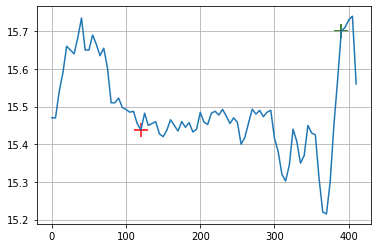

[(49, 15.08)]


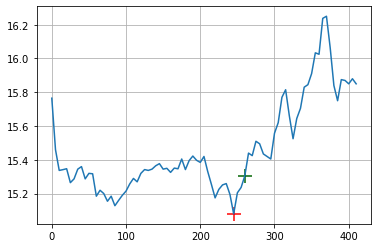

[]


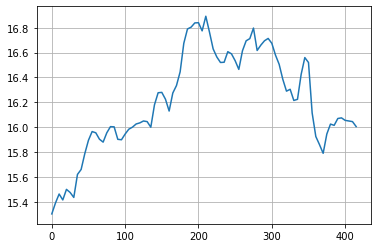

[(24, 14.504999999999999), (52, 14.504999999999999)]


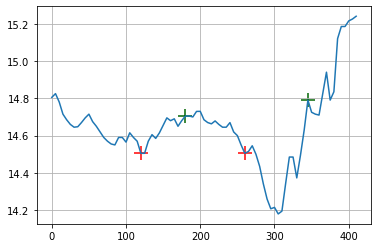

[]


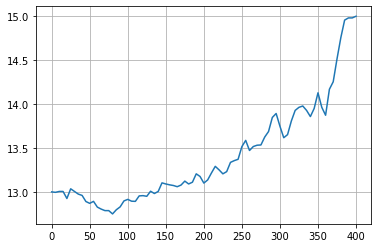

[(74, 12.235)]


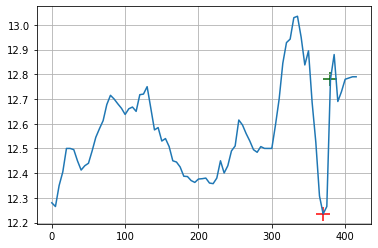

[(69, 12.6996)]


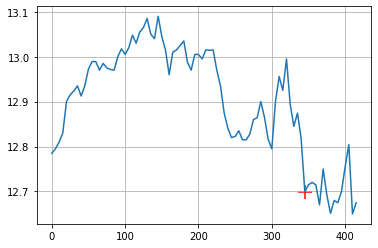

[(59, 12.945)]


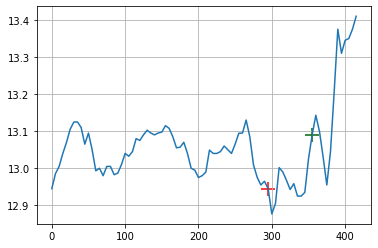

[]


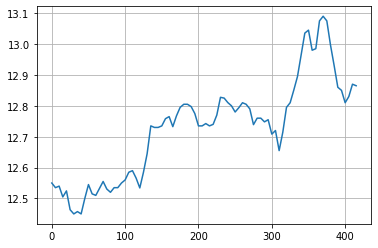

[(28, 12.645), (73, 12.60505), (77, 12.515)]


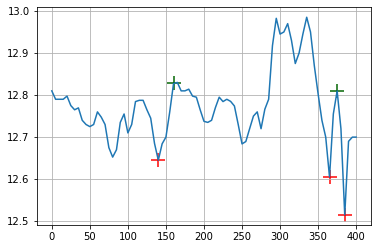

[]


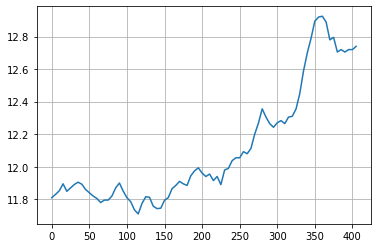

[(56, 12.4413), (70, 12.44)]


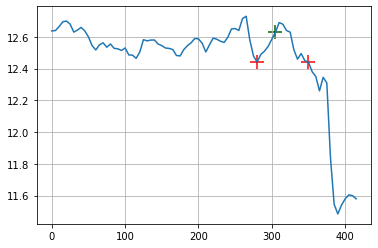

[(24, 12.375)]


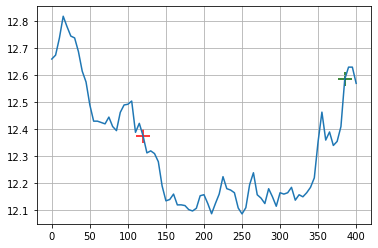

[]


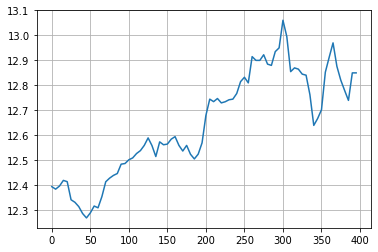

[(61, 12.225)]


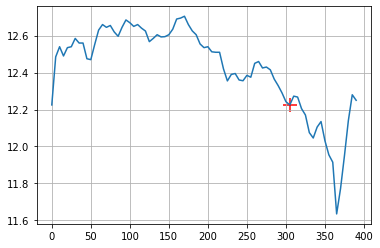

[(27, 11.809999999999999), (73, 11.700849999999999)]


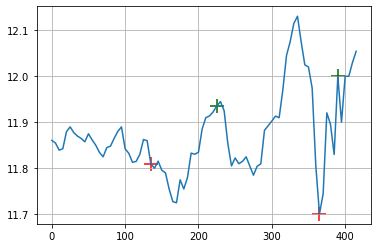

[(53, 12.105)]


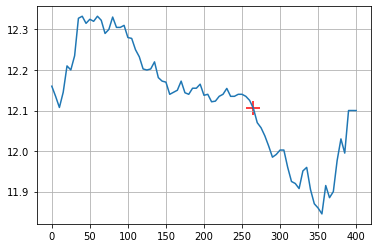

[(35, 12.23), (60, 12.2105)]


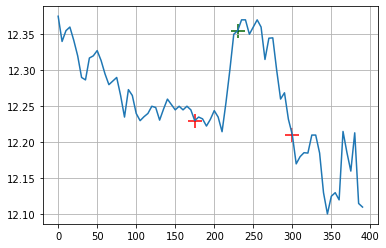

[(47, 11.905000000000001)]


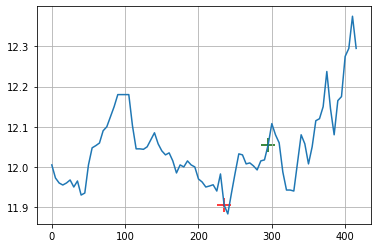

In [21]:
curate_data("SPY")for d in list_data_per_day:
    
    min_first_hours = np.min(d[:24])
    argmin_first_hours = np.argmin(d[:24])
    global_minimum = min_first_hours
    
    sell_price = 0
    
    list_buy = []
    list_sell = []
    
    buy = True
    sell = False
    
    counter = 24
    for entry in d[24:]:
        
        if entry < global_minimum:
            global_minimum = entry
        
        if entry <= global_minimum and buy:
            list_buy.append((counter, entry))
            
            buy = False
            sell = True
            
        if entry > min_first_hours*1.01 and sell:
            
            list_sell.append((counter, entry))
            
            buy = True
            sell = False
        
        counter += 1
    
    print(list_buy)
        
    
    plt.plot()
    plt.grid(True)
    plt.plot(np.arange(len(d))*5, d)
    plt.scatter(np.array([l[0] for l in list_buy])*5, [l[1] for l in list_buy], marker = "+", c = "red", s=200)
    plt.scatter(np.array([l[0] for l in list_sell])*5, [l[1] for l in list_sell], marker = "+", c = "darkgreen", s=200)
    plt.show()

# correlation analysis

In [71]:
from scipy.stats import pearsonr
import re
import time 

In [126]:
def curate_data(symbol, period):
    
    data = get_historical_data(symbol, period)
    date_array, data_array = remove_after_hour_data(data, period)
    list_data_per_day = split_data_by_day(date_array, data_array)
    
    return list_data_per_day

In [127]:
list_stocks = pickle.load(open("stocks_with_weeklies.p", "rb"))

In [136]:
spy_data = curate_data("SPY", "Daily")
num_days_spy = len(spy_data)

In [ ]:
list_corr = []

for symbol in list_stocks:
    
    time.sleep(12)
    
    try:
        
        symbol = re.findall("[A-Z]+", symbol[0])[0]
        symbol_data = curate_data(symbol, "Daily")
        
        diff = 0
        if len(symbol_data) < num_days_spy:
            diff = num_days_spy - len(symbol_data) 
            
        corr = pearsonr(np.array(spy_data[diff:]).flatten(), np.array(symbol_data).flatten())
        list_corr.append((corr[0], symbol))
        
        print(f"The correlation between SPY and {symbol} is {corr[0]}")
            
    except (requests.exceptions.RequestException, ValueError, UnboundLocalError, IndexError, KeyError) as e:
        print("caught", e, symbol)
        

The correlation between SPY and AAOI is -0.5916945468805237


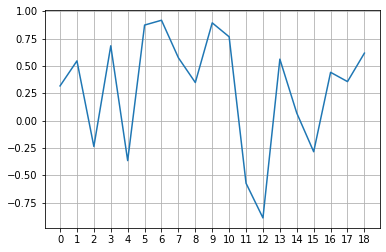

In [43]:
plt.plot()
plt.grid(True)
plt.plot(range(len(list_corr)), [l[0] for l in list_corr])
plt.xticks(np.arange(0, 19, 1))
plt.show()